In [364]:
import pprint
import arviz as az
import corner
import emcee
import george
import matplotlib.pyplot as plt
import numpy as np
import radvel
import scipy.optimize as op
from astropy.table import Table
from george import kernels
from george.gp import LinAlgError
from radvel.plot import mcmc_plots, orbit_plots
import yaml
from matplotlib import cm
import pandas as pd
from PyAstronomy.pyasl import foldAt
import rv_analysis_tools as rv
import importlib
importlib.reload(rv)
from scipy.optimize import minimize

## Target selection

In [365]:
star = input('Enter star name:')

print('Loading input file and data...')
### System info
working_path = f"stars/{star}/"

# Read input file
try: 
    with open(working_path + 'input.yaml', 'r') as file:
        yaml_file = yaml.safe_load(file)
except FileNotFoundError:
    print('This star does not exist in the database.')
    raise


Loading input file and data...


## Loading data

In [366]:
data = rv.DataLoader(yaml_file)

Matplotlib preferences

In [367]:
# Styling parameters
plt.style.use('ggplot')
plt.rcParams.update({
    'font.size': 12,
    'font.family': 'serif',
    'legend.fontsize': 'small',
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'small',
    'ytick.labelsize':'small',
    'figure.autolayout': True,
})

colors = plt.cm.coolwarm(np.linspace(1, 0, len(data.instruments)))

# Activity indicators

In [368]:
param_names = ['mu', 'log_wn', 'log_amp', 'log_lambda', 'gamma', 'log_Prot']

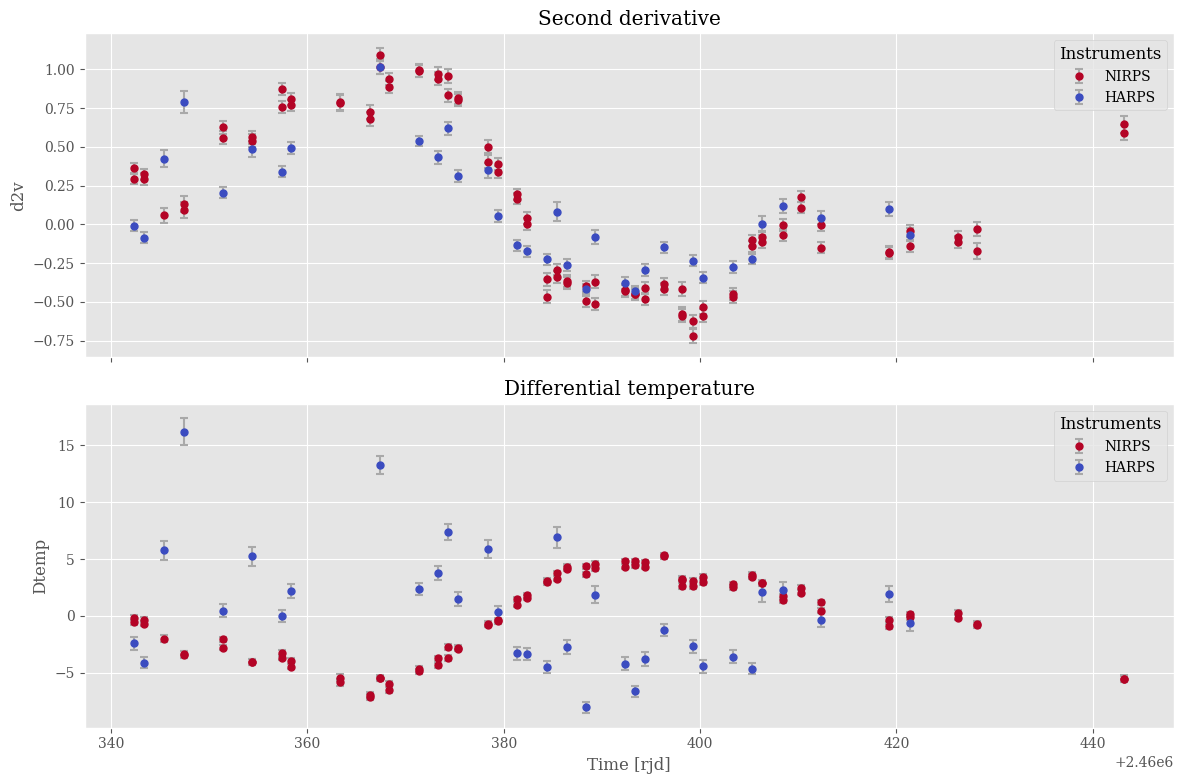

In [369]:
# Plot the chosen activity indicator
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

for idx, instrument in enumerate(data.instruments):
    # Subtler error bars
    axes[0].errorbar(data.t_rv[instrument], data.d2v[instrument], yerr=data.sd2v[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
    
    axes[1].errorbar(data.t_rv[instrument], data.Dtemp[instrument], yerr=data.sDtemp[instrument], fmt='o',
                     label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)

axes[1].set_xlabel('Time [rjd]')
axes[0].set_ylabel('d2v')
axes[1].set_ylabel('Dtemp')
axes[0].legend(title='Instruments')
axes[1].legend(title='Instruments')
axes[0].set_title('Second derivative')
axes[1].set_title('Differential temperature')
plt.show()

Choose the activity indicator

In [370]:
if data.activity_priors['chosen_activity'] == 'd2v': 
    print('Activity indicator chosen:', data.activity_priors['chosen_activity'])
    act, sact = data.d2v, data.sd2v

if data.activity_priors['chosen_activity'] == 'Dtemp': 
    print('Activity indicator chosen:', data.activity_priors['chosen_activity'])
    act, sact = data.Dtemp, data.sDtemp

Activity indicator chosen: d2v


## Creating the GP object

GP params order: 

0. `mu` (offset)
1. `log_wn` (jitter noise)
2. `log_amp` (amplitude)
3. `log_lambda` (Coherence length)
4. `gamma` (Number of sub-structures)
5. `log_Prot` (Rotation period)

First Guess

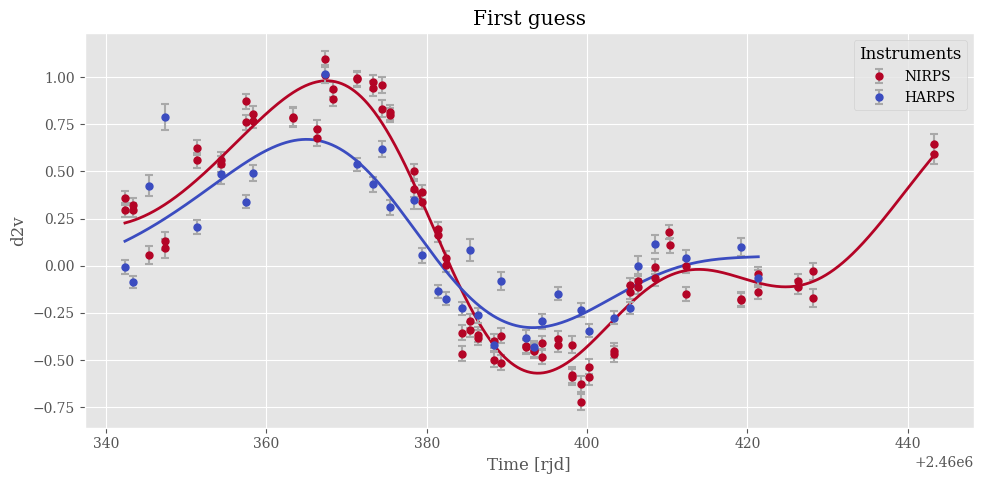

In [371]:
act_gp = {} # Dictionary to store the GP for each instrument
p0 = {} # Dictionary to store the initial guess for the hyperparameters

for instrument in data.instruments: 
    
    p0[instrument] = rv.juliet_to_george([np.mean(act[instrument]), 0.1, np.std(act[instrument]),
           data.activity_priors['GP_length']['guess'], data.activity_priors['GP_gamma']['guess'], data.activity_priors['GP_Prot']['guess']]) # Initial guess for the hyperparameters
    
    act_gp[instrument] = rv.QP_GP_Model(p0[instrument], data.t_rv[instrument], act[instrument], sact[instrument])
# Plot the first guess
# Plot the chosen activity indicator
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
                    
for idx, instrument in enumerate(data.instruments):
    # Subtler error bars
    ax.errorbar(data.t_rv[instrument], act[instrument], yerr=sact[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
    ax.plot(data.t_mod[instrument], act_gp[instrument].predict(data.t_mod[instrument]), color=colors[idx], lw=2)

ax.set_xlabel('Time [rjd]')
ax.set_ylabel(data.activity_priors['chosen_activity'])
ax.legend(title='Instruments')
ax.set_title('First guess')
plt.show()

Quick Optimization (Not required)

In [372]:
# # Define the objective function for optimization
# def objective(params, gp_model, y_rv):
#     gp_model.gp.set_parameter_vector(params)
#     return -gp_model.gp.log_likelihood(y_rv)


# # Optimize hyperparameters and initialize GP models
# for instrument in data.instruments:
    
#     # Create initial GP model
#     initial_gp_model = rv.QP_GP_Model(p0[instrument], data.t_rv[instrument], act[instrument], sact[instrument])
    
#     # Optimize the hyperparameters
#     result = minimize(objective, p0[instrument], args=(initial_gp_model, act[instrument]), method='Powell')
    
#     # Store the optimized GP model
#     optimized_params = result.x
#     act_gp[instrument] = rv.QP_GP_Model(optimized_params, data.t_rv[instrument], act[instrument], sact[instrument])
    
#     # Update the initial guess with the optimized parameters
#     p0[instrument] = optimized_params

# # Plot the first guess
# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# colors = cm.coolwarm(np.linspace(0, 1, len(data.instruments)))

# for idx, instrument in enumerate(data.instruments):
#     # Subtler error bars
#     ax.errorbar(data.t_rv[instrument], act[instrument], yerr=np.sqrt(sact[instrument]**2 + np.exp((p0[instrument][1]))**2), fmt='o', 
#                 label=instrument, color=colors[idx], 
#                 ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
#     ax.plot(data.t_mod[instrument], act_gp[instrument].predict(data.t_mod[instrument]), color=colors[idx], lw=2)

# ax.set_xlabel('Time [rjd]')
# ax.set_ylabel(data.activity_priors['chosen_activity'])
# ax.legend(title='Instruments')
# ax.set_title('First guess')
# plt.show()


## Defining the posterior function

In [373]:
# Posterior function
def act_log_post(p, gp_models, act, data, i_shared) -> float:
    # Separate the parameters for each instrument
    separated_params = rv.separate_params(p, i_shared, gp_models.keys())

    log_prob_tot = 0
    for instrument, gp_model in gp_models.items():
        gp_params = separated_params[instrument]
        log_prob = rv.gp_log_prior(gp_params, data.activity_priors)
        
        if np.isfinite(log_prob):
            gp_model.gp.set_parameter_vector(gp_params)
    
            log_prob_tot += log_prob + gp_model.gp.log_likelihood(act[instrument])
        else:
            return -np.inf
    
    
    return log_prob_tot


## Combining the shared parameters and computing initial guess

In [374]:
################################################
# Parameters to be shared between NIRPS and HARPS
i_indiv = data.activity_priors['individual_params'] # Indices of the parameters that are instrument-specific
i_shared = data.activity_priors['shared_params'] # Indices of the parameters that are shared between the instruments
################################################

In [375]:
comb_p0, labels = rv.create_combined_params(p0, i_shared, param_names)

## Running `emcee`

In [376]:
# MCMC fit of the GP hyperparameters 
nwalkers, ndim = 32, len(comb_p0)
num_warmup = 600
num_post_samples = 2500
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    act_log_post,
    args=(act_gp, act, data, i_shared),
    # moves=[emcee.moves.StretchMove()]
    moves=[emcee.moves.DEMove()],
)
# Change the dimension of p0 with the number of walkers
comb_p0 = np.array([comb_p0 + 1e-6 * np.random.randn(ndim) for i in range(nwalkers)])

$\color{red}{\textrm{RUNNING CELL}}$

Running MCMC fit of the GP hyperparameters...


  0%|          | 12/3100 [00:00<02:56, 17.45it/s]

100%|██████████| 3100/3100 [02:13<00:00, 23.22it/s]


Done
Summary for joint fit

--------------------------
                mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_NIRPS       0.278  0.639  -0.976    1.503      0.031    0.024     543.0   
mu_HARPS       0.100  0.336  -0.571    0.670      0.019    0.018     507.0   
log_wn_NIRPS  -5.241  0.239  -5.685   -4.796      0.007    0.005    1125.0   
log_wn_HARPS  -3.577  0.321  -4.196   -3.001      0.011    0.008     855.0   
log_amp_NIRPS -0.306  0.697  -1.549    1.025      0.031    0.022     559.0   
log_amp_HARPS -1.781  0.738  -3.142   -0.392      0.037    0.026     477.0   
log_lambda     8.657  0.858   7.378   10.075      0.044    0.031     400.0   
gamma          2.739  0.923   0.899    3.999      0.062    0.044     289.0   
log_Prot       4.202  0.150   3.876    4.472      0.012    0.009     287.0   

               ess_tail  r_hat  
mu_NIRPS          450.0   1.04  
mu_HARPS          268.0   1.05  
log_wn_NIRPS     1511.0   1.03  
log_wn_HARPS     1929.0   1.03  

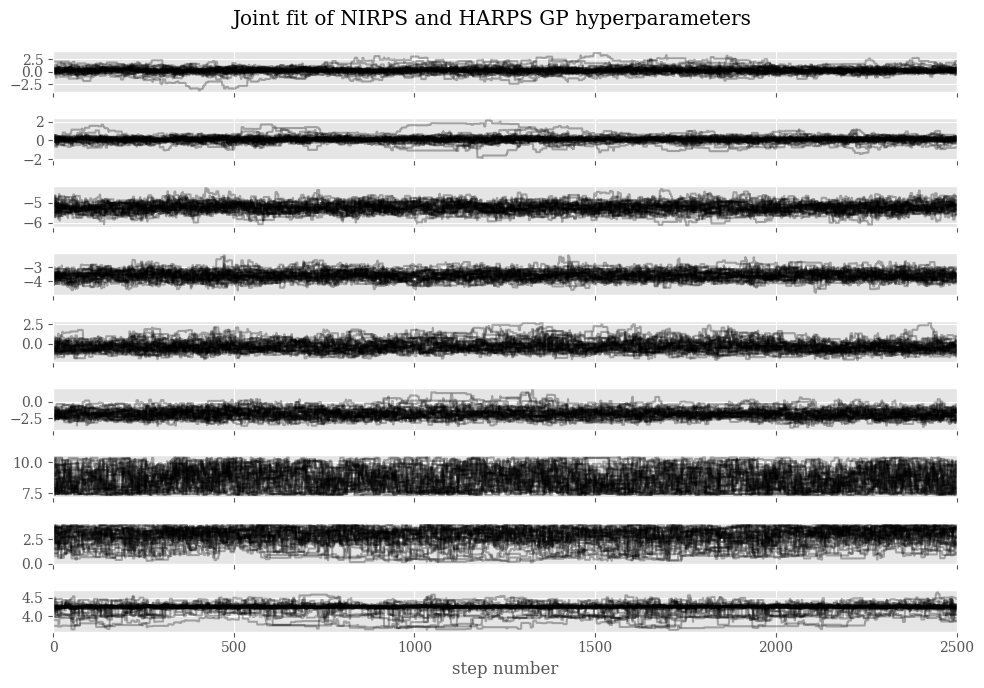

In [377]:
print('Running MCMC fit of the GP hyperparameters...')
sampler.run_mcmc(comb_p0, num_post_samples + num_warmup, progress=True, store=True)
print('Done')

inf_data = az.from_emcee(sampler, var_names=labels)
inf_data = inf_data.sel(draw=slice(num_warmup, None))

#MCMC summary
print(f"Summary for joint fit\n")
print('--------------------------')
print(az.summary(inf_data))

fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
post_samples = sampler.get_chain(discard=num_warmup)

# Save the posterior samples
np.save(f'stars/{star}/joint_fit/act_post_samples.npy', post_samples)

for i in range(ndim):
    ax = axes[i]
    ax.plot(post_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(post_samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.suptitle('Joint fit of NIRPS and HARPS GP hyperparameters')
plt.savefig(f"stars/{star}/joint_fit/act_GP_traceplot.png")

Load the already ran target

In [378]:
post_samples = np.load(f"stars/{star}/joint_fit/act_post_samples.npy")

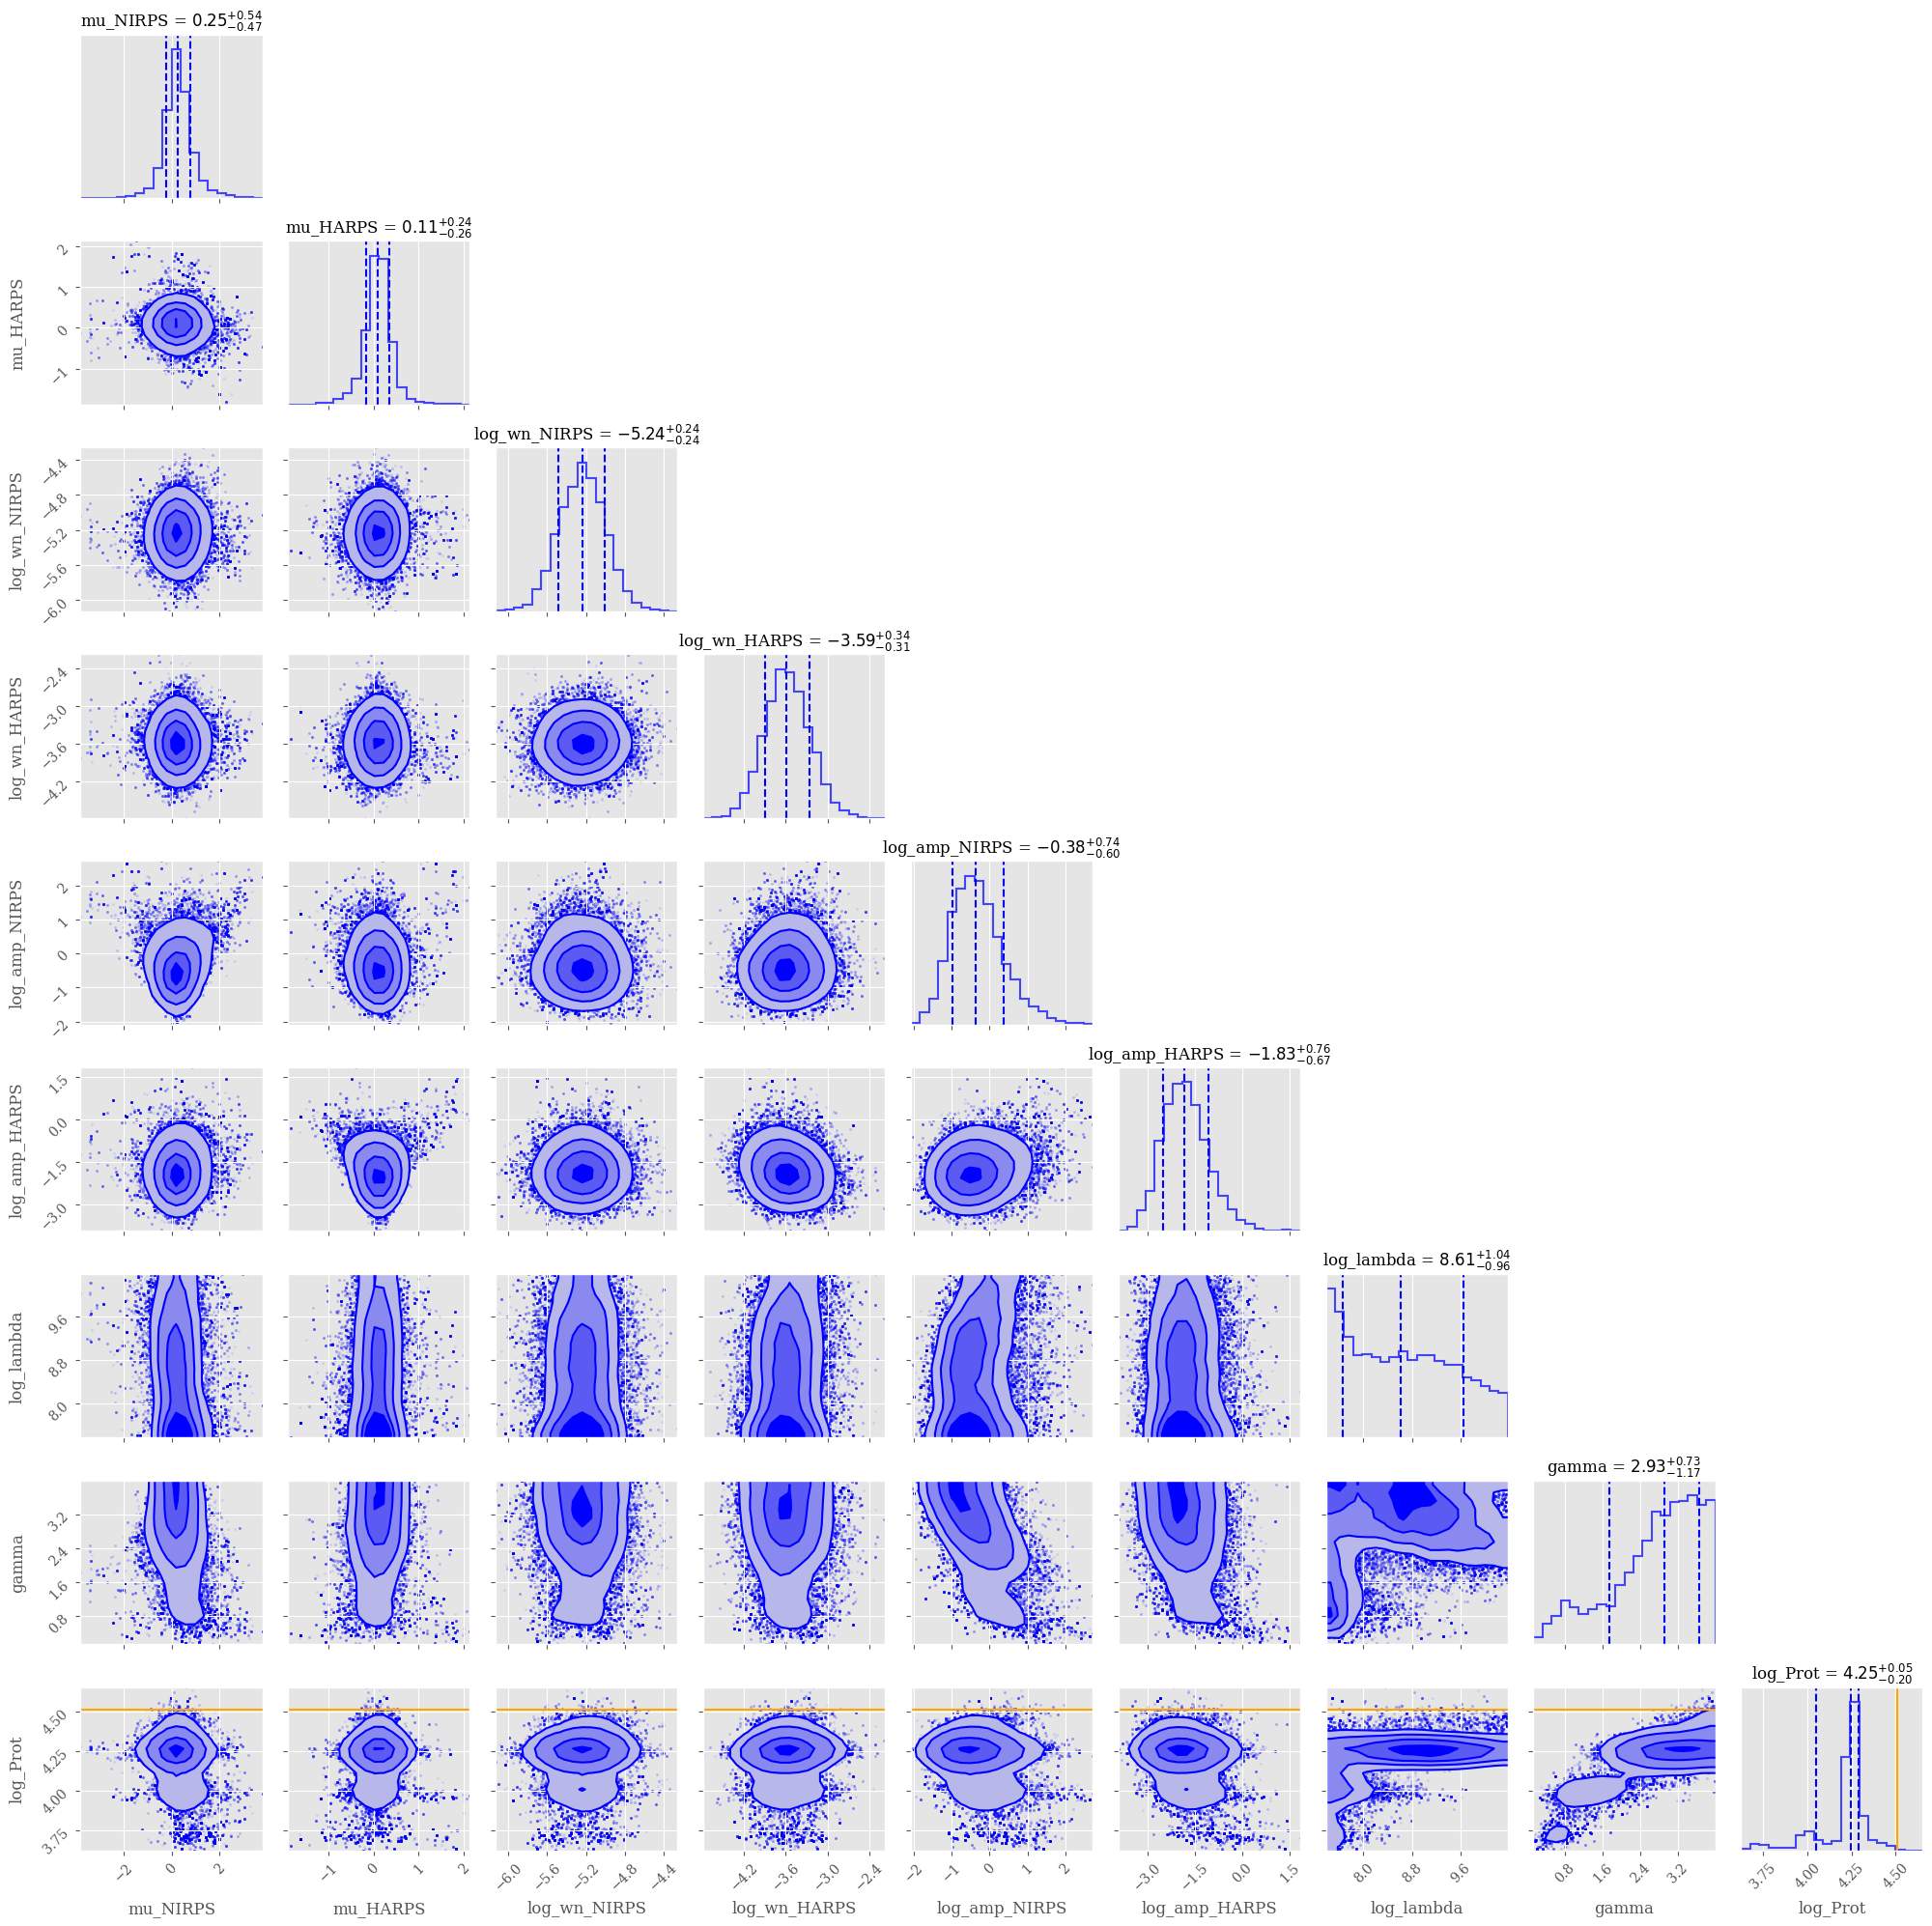

In [379]:
truths = [None, None, None, None, None, None, None, None, np.log(data.data['star']['period'])]

corner.corner(inf_data, quantiles=[0.16, 0.5, 0.84],
              show_titles=True,
              title_kwargs={"fontsize": 12},
              color="blue",  # Set a color scheme (optional)
              hist_kwargs={"linewidth": 1.5, "alpha": 0.7},  # Adjust histogram appearance
              fill_contours=True,  # Show contours for data density
              fill_kw={"cmap": "Blues"},  # Set colormap for contours (optional)
              smooth=True,  # Improve smoothness of contours
              fontsize=10,  # Set font size for labels and tick marks
              truths=truths,
              truth_color = 'orange',
)
plt.tight_layout()
plt.savefig(f"stars/{star}/joint_fit/act_GP_cornerplot.png")

In [380]:
np.shape(post_samples)

(2500, 32, 9)

In [381]:
median_likelihood_params = np.median(post_samples, axis=(0,1))

print(f"Median likelihood parameters")
print('--------------------------')
print(median_likelihood_params)


Median likelihood parameters
--------------------------
[ 0.24524204  0.10536117 -5.2397942  -3.58756245 -0.37738601 -1.83161341
  8.61100321  2.92897847  4.24536177]


Creating posterior samples

In [382]:
# Visualize posterior samples and max/median likelihood models
print('Creating posterior samples...')

num_display = 50
maxiter = 100
niter = 0

# Initialize dictionaries to store posterior samples for each instrument
model_post_samples = {instrument: [] for instrument in act_gp.keys()}

while niter < maxiter and all(len(samples) < num_display for samples in model_post_samples.values()):
    w = np.random.randint(nwalkers)
    n = np.random.randint(num_post_samples)

    # Separate the parameters for each instrument
    post_samples_dict = rv.separate_params(post_samples[n, w], i_shared, act_gp.keys())

    try:
        for instrument, gp_model in act_gp.items():
            gp_params = post_samples_dict[instrument]
            gp_model.gp.set_parameter_vector(gp_params)
            model_post_samples[instrument].append(gp_model.gp.sample_conditional(act[instrument], data.t_mod[instrument]))
    except LinAlgError:
        print("LinAlgError")
        print(f"iteration {niter}")
        print("GP hyperparameters:")
        for instrument, gp_model in act_gp.items():
            pprint.pprint(gp_model.gp.get_parameter_dict())
    
    niter += 1

# Convert lists to numpy arrays
model_post_samples = {instrument: np.array(samples) for instrument, samples in model_post_samples.items()}

Creating posterior samples...


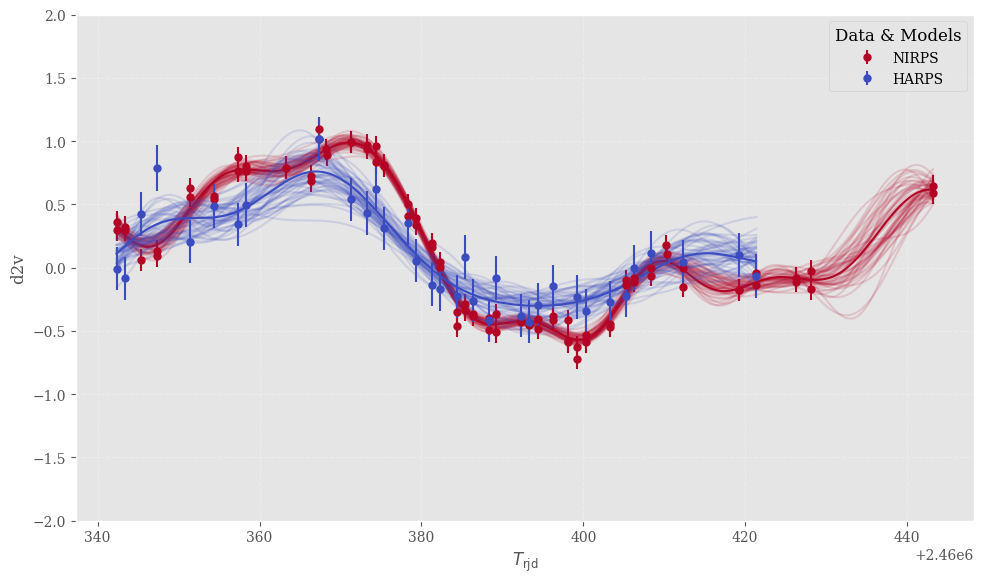

In [383]:
# Separate the parameters for each instrument
med_params = rv.separate_params(median_likelihood_params, i_shared, act_gp.keys())

# Initialize dictionaries to store predictions and standard deviations
mu_med = {}
std_med = {}

# Predict for each instrument
for instrument, gp_model in act_gp.items():
    # Median likelihood parameters
    gp_model.gp.set_parameter_vector(med_params[instrument])
    mu_med[instrument], var_med = gp_model.gp.predict(act[instrument], data.t_mod[instrument], return_var=True)

# Plotting
fig, axes = plt.subplots(1, 1, figsize=(10, 6), sharex=True)
colors = cm.coolwarm(np.linspace(1, 0, len(act_gp)))  # Use coolwarm colormap for consistency

for idx, (instrument, color) in enumerate(zip(act_gp.keys(), colors)):
    # Plot data with error bars
    axes.errorbar(data.t_rv[instrument], act[instrument], yerr=np.sqrt(sact[instrument]**2 + np.exp(med_params[instrument][1])), 
                  fmt="o", ms=5, label=instrument, color=color)
    
    # Plot samples from posterior
    axes.plot(data.t_mod[instrument], model_post_samples[instrument].T, color=color, alpha=0.15)
    
    # Plot median likelihood
    axes.plot(data.t_mod[instrument], mu_med[instrument], color=color, linewidth=1.5)

# Axes and labels
axes.set_ylabel(f"{data.activity_priors['chosen_activity']}")
axes.set_xlabel(r"$T_{\rm rjd}$")  # Use Latex for unit

# Conditionally setting y-limits based on activity indicator
if data.activity_priors['chosen_activity'] == 'Dtemp': 
    plt.ylim(bottom=-50, top=50)
if data.activity_priors['chosen_activity'] == 'd2v': 
    plt.ylim(bottom=-2, top=2)

axes.grid(linestyle='--', alpha=0.3)
plt.legend(title="Data & Models", loc='upper right')  # Adjust legend position
plt.tight_layout()  # Adjust spacing

# Saving figure
star_name = data.data['star']['name']
file_path = f"stars/{star_name}/joint_fit/{data.activity_priors['chosen_activity']}_GP_MC_fit.png"
plt.savefig(file_path, dpi=300)  # Ensure high resolution


In [384]:
import importlib
importlib.reload(rv)

<module 'rv_analysis_tools' from '/home/plamontagne/nirps/rv_analysis_tools.py'>

# Planets + GP analysis

# Definition of the parameter vector: 

p = [planets parameters, GP parameters]

['mu', 'noise', 'GP_sigma', 'GP_length', 'GP_gamma', 'GP_Prot']

In [385]:
def log_post(p_combined, model, data, i_shared) -> float:
    num_planets = model.num_planets
    planet_params = p_combined[:3*num_planets]
    gp_params_combined = p_combined[3*num_planets:]
    
    # Separate the GP parameters for each instrument
    separated_gp_params = rv.separate_params(gp_params_combined, i_shared, data.instruments)
    
    # Interleave the GP parameters for each instrument
    interleaved_gp_params = []
    num_params_per_instrument = len(next(iter(separated_gp_params.values())))
    
    for param_idx in range(num_params_per_instrument):
        for instrument in data.instruments:
            interleaved_gp_params.append(separated_gp_params[instrument][param_idx])
    
    # Combine planet parameters with interleaved GP parameters for updating the model
    model_params = np.concatenate([planet_params, interleaved_gp_params])
    
    model.update_params(model_params)

    # Calculate log prior for the GP hyperparameters and the planet parameters
    gp_log_prob = 0
    for instrument, gp_params in separated_gp_params.items():
        gp_log_prob += rv.gp_log_prior(gp_params, data.RV_priors)
    
    planet_log_prior = rv.planet_log_prior(planet_params, data.RV_priors)
    
    if np.isfinite(gp_log_prob) and np.isfinite(planet_log_prior):
        try:
            log_prob_tot = gp_log_prob + planet_log_prior + model.log_likelihood()
            if np.isnan(log_prob_tot) or not np.isfinite(log_prob_tot):
                return -np.inf
            return log_prob_tot
        except np.linalg.LinAlgError:
            return -np.inf

    return -np.inf


Defining the planets parameters

In [386]:
# Extract the number of planets from the RV priors
num_planets = data.RV_priors['nplanets']

# Initialize lists to hold planet parameters and labels
planet_params = []
planet_labels = []

# Loop over the number of planets to construct the parameter and label lists
for i in range(1, num_planets + 1):
    try: 
        planet_params.extend([
            data.RV_priors[f'per{i}']['guess'],
            data.RV_priors[f'tc{i}']['guess'],
            data.RV_priors[f'k{i}']['guess']
        ])
        planet_labels.extend([f'per{i}', f'tc{i}', f'k{i}'])
    except:
        raise ValueError(f"Planet {i} does not have all the necessary priors defined.")

## Creating planet + GP model

Using the priors from the `.yaml` file

In [387]:
new_gp_p0 = {}

for instrument in data.instruments: 
    
    new_gp_p0[instrument] = rv.juliet_to_george([np.mean(data.y_rv[instrument]), 0.1, np.std(data.y_rv[instrument]),
           data.RV_priors['GP_length']['guess'], data.RV_priors['GP_gamma']['guess'], data.RV_priors['GP_Prot']['guess']]) # Initial guess for the hyperparameters

Choosing to use the activity indicators or not

In [388]:
# Loop through each parameter index
for idx in range(6): 
    if idx < 3:
        continue
    else:
        for instrument in data.instruments: 
            if data.RV_priors['use_indicator'] == True:
                new_gp_p0[instrument][idx] = med_params[instrument][idx]
            else: 
                if idx == 3: new_gp_p0[instrument][idx] = data.RV_priors['GP_length']['guess']
                if idx == 4: new_gp_p0[instrument][idx] = data.RV_priors['GP_gamma']['guess']
                if idx == 5: new_gp_p0[instrument][idx] = data.RV_priors['GP_Prot']['guess']

gp_params = rv.interleave_params(new_gp_p0)
p0_model = planet_params + gp_params
model = rv.Planet_GP_Model(p0_model, data.t_rv, data.y_rv, data.yerr_rv, num_planets = num_planets)

# Combined first guess 
gp_comb_p0, labels = rv.create_combined_params(new_gp_p0, i_shared, param_names)

comb_p0 = planet_params + gp_comb_p0

Look at first guess

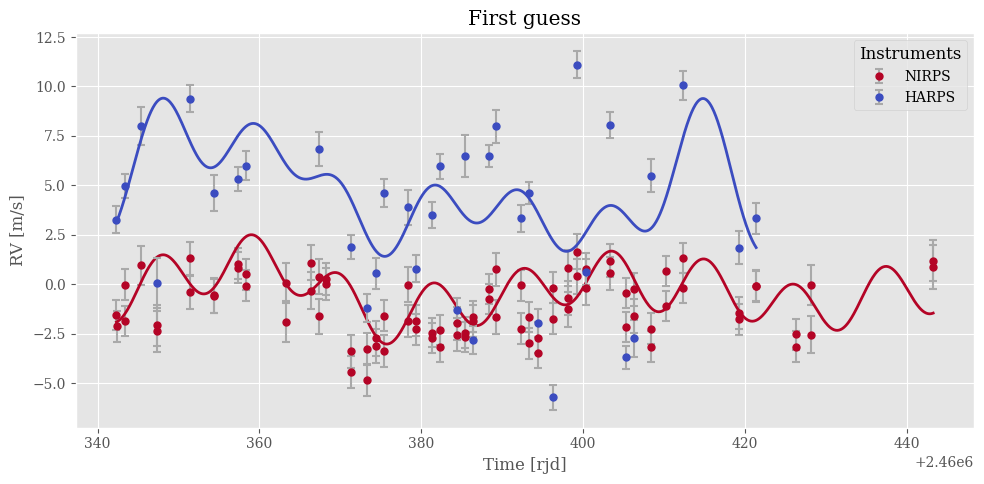

In [389]:
# Plot the RV data and the first guess
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
colors = cm.coolwarm(np.linspace(1, 0, len(data.instruments)))

for idx, instrument in enumerate(data.instruments):
    # Subtler error bars
    ax.errorbar(data.t_rv[instrument], data.y_rv[instrument], yerr=data.yerr_rv[instrument], fmt='o', 
                label=instrument, color=colors[idx], 
                ecolor='darkgray', elinewidth=1.5, capsize=3, capthick=1.5)
    ax.plot(data.t_mod[instrument], model.predict(data.t_mod)[instrument], color=colors[idx], lw=2)
    
ax.set_xlabel('Time [rjd]')
ax.set_ylabel('RV [m/s]')
ax.legend(title='Instruments')
ax.set_title('First guess')
plt.show()
    

In [390]:
# MCMC fit of the GP hyperparameters 
nwalkers, ndim = 32, len(comb_p0)
num_warmup = 600
num_post_samples = 2500
sampler = emcee.EnsembleSampler(
    nwalkers,
    ndim,
    log_post,
    args=(model, data, i_shared),
    moves=[emcee.moves.DEMove()]
)
# Change the dimension of p0 with the number of walkers
comb_p0_emcee = np.array([comb_p0 + np.random.randn(ndim) * 1e-4 for i in range(nwalkers)])

In [391]:
sampler.run_mcmc(comb_p0_emcee, num_post_samples + num_warmup, progress=True)

100%|██████████| 3100/3100 [05:16<00:00,  9.78it/s]


State([[ 1.14265253e+01  6.43545534e+01  1.34091475e+00  4.41018422e+11
  -1.34874928e+10  2.04119850e+11  8.58915318e-01  5.51201685e+00
  -1.27498356e+01 -1.81841468e+00  9.08479225e+00  7.90033585e+00
   7.85436995e+00  9.77413269e+00  3.19681234e+00]
 [ 1.05070585e+01  6.06427185e+01  1.31513053e+00  2.10362184e+12
  -6.67920776e+10  9.71654564e+11 -1.87069145e+00 -8.33445422e-01
  -1.22450570e+01 -5.47381698e+00  7.57787290e+00  9.20275576e+00
   8.30952424e+00  8.20410498e+00  2.88800006e+00]
 [ 1.07872714e+01  7.73110727e+01  1.22942686e+00 -9.76634386e+11
   3.00833495e+10 -4.51850876e+11  9.68760505e-02  3.28404150e+00
  -4.59584998e+00 -1.27356437e+01  8.53076438e+00  8.30523007e+00
   7.95336346e+00  8.04086794e+00  3.19396323e+00]
 [ 1.09560080e+01  7.03810765e+01  1.20020628e+00 -1.35347617e+12
   4.14665591e+10 -6.26381876e+11 -3.75260139e+00 -6.12176228e+00
  -7.11537337e+00 -7.86510503e+00  7.18313067e+00  8.76972787e+00
   7.91604267e+00  6.34158291e+00  2.88469085e+00

In [392]:
fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
post_samples = sampler.get_chain(discard=num_warmup)

# Save the posterior samples
np.save(f'stars/{star}/joint_fit/full_post_samples.npy', post_samples)

for i in range(ndim):
    ax = axes[i]
    ax.plot(post_samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(post_samples))
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number")
plt.suptitle('Joint fit of NIRPS and HARPS planet + GP')
plt.savefig(f"stars/{star}/joint_fit/planet+GP_traceplot.png")

In [ ]:
post_samples = np.load(f"stars/{star}/joint_fit/full_post_samples.npy")
np.median(post_samples, axis=(0,1))

array([ 1.11494529e+01,  7.52978221e+01,  1.23714718e+00,  4.71194294e-01,
       -5.76685749e-02, -6.41351284e+00, -7.56733340e+00,  8.10746386e+00,
        8.73032897e+00,  8.21957249e+00,  8.56375901e+00,  2.93127749e+00])

In [ ]:
# Visualize posterior samples and max/median likelihood models
print('Creating posterior samples...')

num_display = 50
maxiter = 100
niter = 0

# Initialize dictionaries to store posterior samples for each instrument
model_post_samples = {instrument: [] for instrument in act_gp.keys()}

while niter < maxiter and all(len(samples) < num_display for samples in model_post_samples.values()):
    w = np.random.randint(nwalkers)
    n = np.random.randint(num_post_samples)

    # Separate the parameters for each instrument
    planet_sample = post_samples[n, w, :3*num_planets]
    gp_samples_dict = rv.separate_params(post_samples[n, w, 3*num_planets:], i_shared, act_gp.keys())
    try:
        for instrument, gp_model in act_gp.items():
            gp_params = rv.interleave_params(gp_samples_dict)
            params = np.concatenate([planet_sample, gp_params])
            model.update_params(params)
            model_post_samples[instrument].append(model.predict(data.t_mod)[instrument])
    except LinAlgError:
        print("LinAlgError")
        print(f"iteration {niter}")
        print("GP hyperparameters:")
        for instrument, gp_model in act_gp.items():
            pprint.pprint(gp_model.gp.get_parameter_dict())
    
    niter += 1

# Convert lists to numpy arrays
model_post_samples = {instrument: np.array(samples) for instrument, samples in model_post_samples.items()}
print('Done')

Creating posterior samples...


Plot the final the planets + GP model

In [ ]:
# Update the model to the median likelihood parameters
med_params = np.median(post_samples, axis=(0,1))
planet_sample = med_params[:3*num_planets]
gp_samples_dict = rv.separate_params(med_params[3*num_planets:], i_shared, act_gp.keys())
gp_params = rv.interleave_params(gp_samples_dict)
params = np.concatenate([planet_sample, gp_params])
model.update_params(params)

# Fetch the noise term of each instrument
noise_terms = {instrument: np.sqrt(data.yerr_rv[instrument]**2 + np.exp(gp_samples_dict[instrument][1])) for instrument in act_gp.keys()}

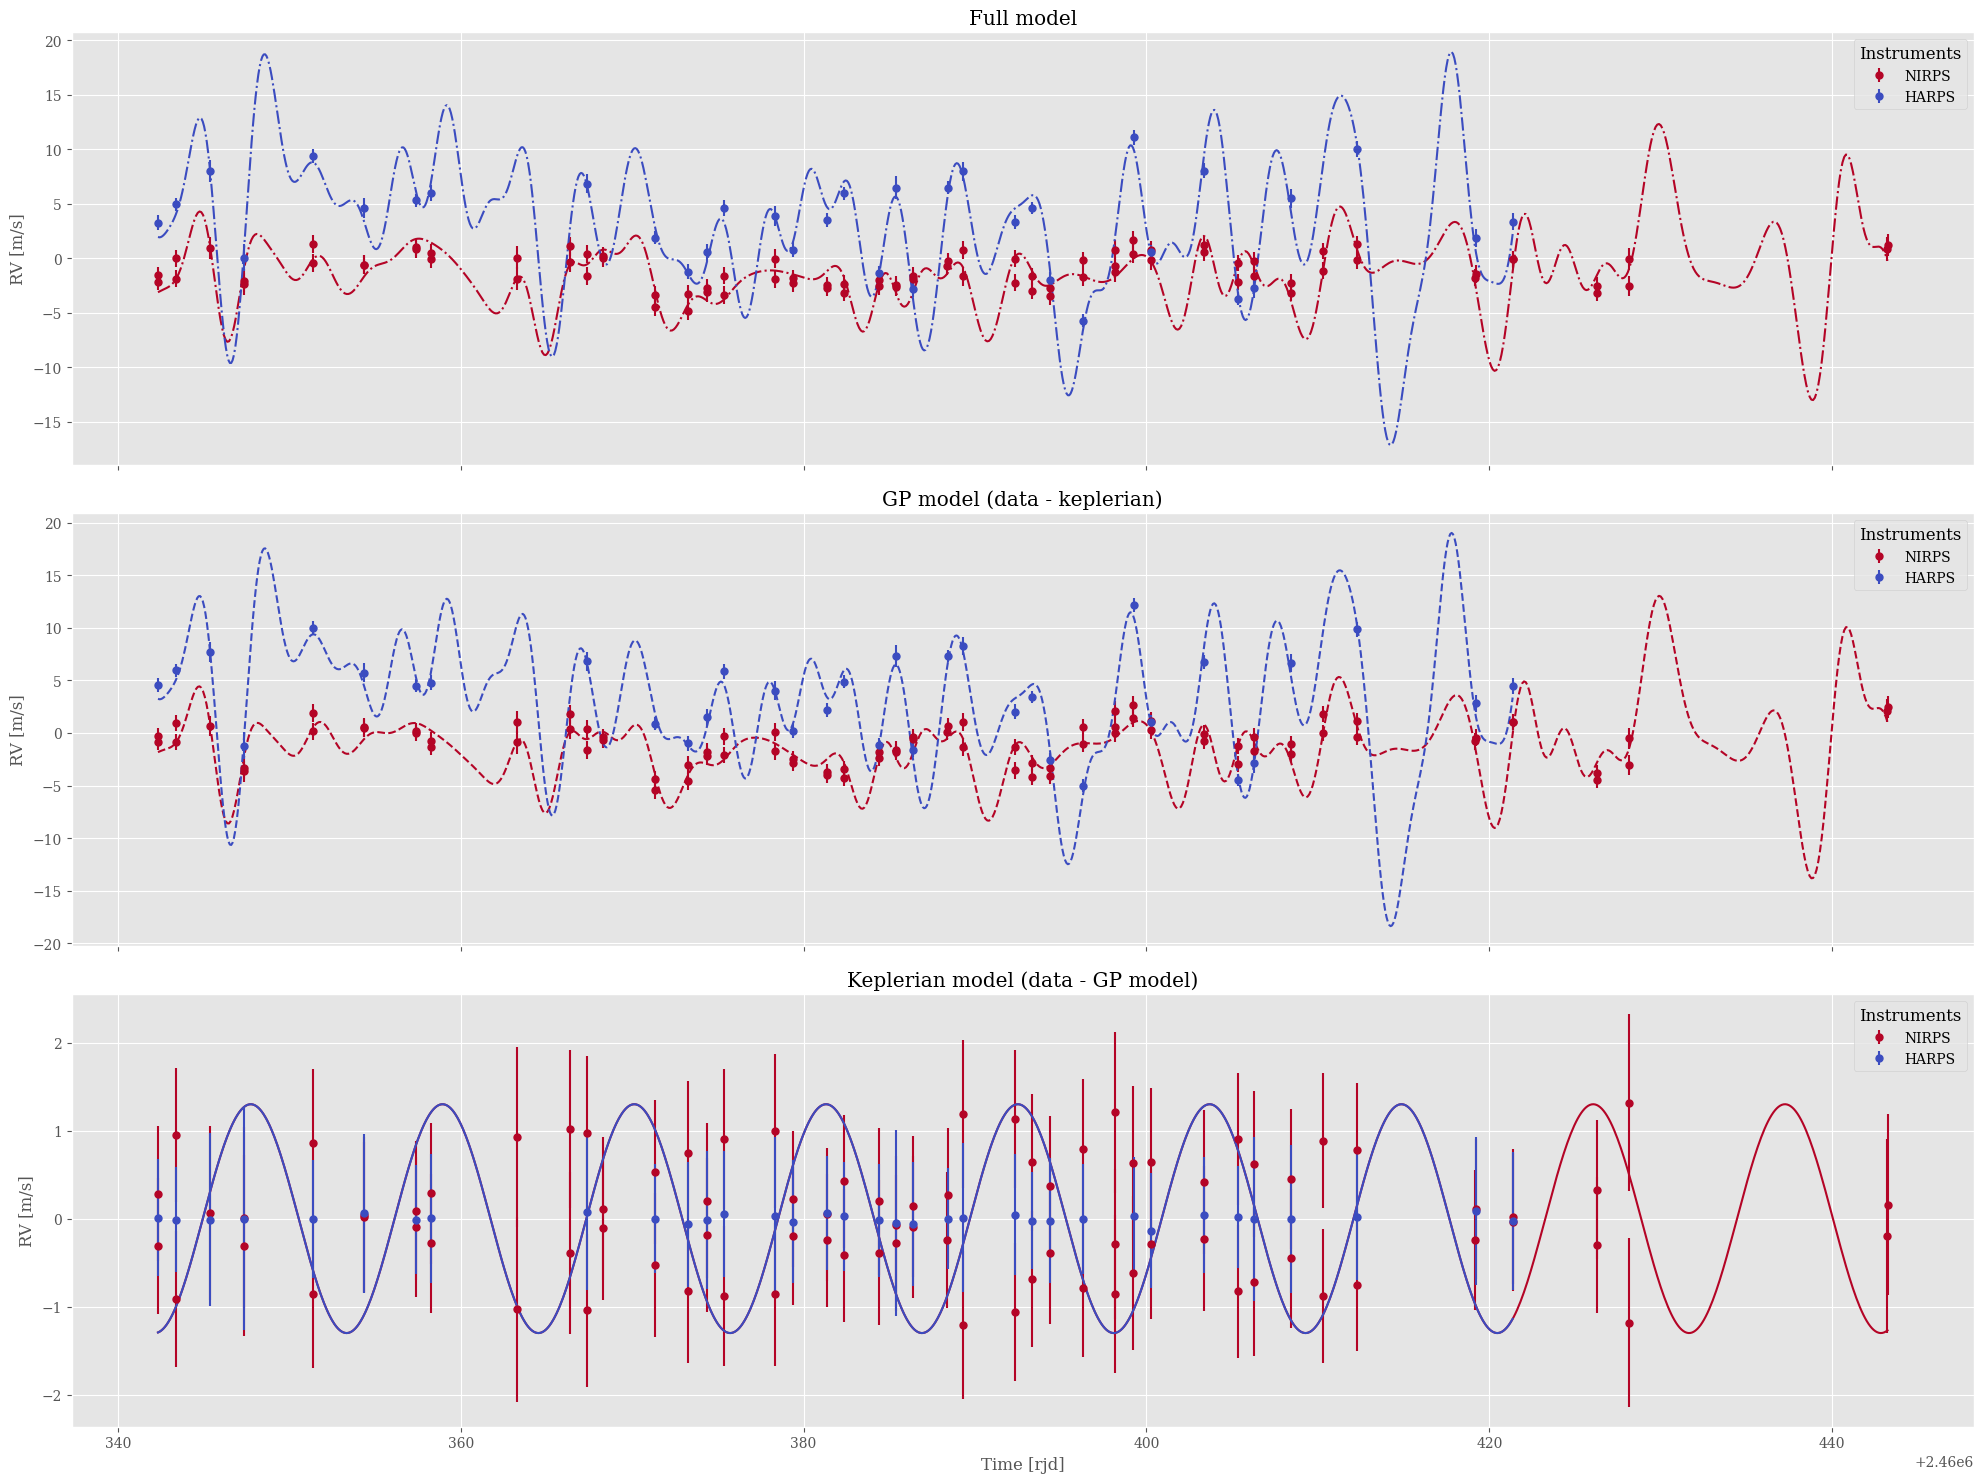

In [ ]:
# Plot the planets + GP model and the samples
fig, axes = plt.subplots(3, 1, figsize=(20, 15), sharex=True)
colors = cm.coolwarm(np.linspace(1, 0, len(data.instruments)))

for idx, instrument in enumerate(data.instruments):
    # Plot data with error bars
    axes[0].errorbar(data.t_rv[instrument], data.y_rv[instrument], yerr=noise_terms[instrument] , fmt="o", ms=5, label=instrument, color=colors[idx])
    axes[1].errorbar(data.t_rv[instrument], data.y_rv[instrument] - model.predict(data.t_rv, return_components=True)[instrument]['planet'], yerr=noise_terms[instrument] , fmt="o", ms=5, label=instrument, color=colors[idx])
    axes[2].errorbar(data.t_rv[instrument], data.y_rv[instrument] - model.predict(data.t_rv, return_components=True)[instrument]['GP'], yerr=noise_terms[instrument] , fmt="o", ms=5, label=instrument, color=colors[idx])
    
    # Plot samples from posterior
    #axes[0].plot(data.t_mod[instrument], model_post_samples[instrument].T, color=colors[idx], alpha=0.15)
    
    # Plot median likelihood
    axes[2].plot(data.t_mod[instrument], model.predict(data.t_mod, return_components=True)[instrument]['planet'], color=colors[idx], linewidth=1.5) #Keplerian
    axes[1].plot(data.t_mod[instrument], model.predict(data.t_mod, return_components=True)[instrument]['GP'], color=colors[idx], linestyle='--', linewidth=1.5) #GP
    axes[0].plot(data.t_mod[instrument], model.predict(data.t_mod, return_components=True)[instrument]['planet'] + model.predict(data.t_mod, return_components=True)[instrument]['GP'],
            color=colors[idx], linestyle='-.', linewidth=1.5) #Full model

axes[0].set_title('Full model')
axes[1].set_title('GP model (data - keplerian)')
axes[2].set_title('Keplerian model (data - GP model)')
axes[2].set_xlabel('Time [rjd]')
axes[0].set_ylabel('RV [m/s]')
axes[1].set_ylabel('RV [m/s]')
axes[2].set_ylabel('RV [m/s]')
axes[0].legend(title='Instruments')
axes[1].legend(title='Instruments')
axes[2].legend(title='Instruments')
ax.set_title(f'{num_planets} planets + GP model')
plt.show()
    

In [ ]:
np.exp(2.93)

18.72763049667292